In [234]:
%matplotlib inline
import pymongo

import numpy as np
import pandas as pd

import seaborn as sns
# import bokeh
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [242]:
# Configuration of the database
client = pymongo.MongoClient("mongodb://localhost:27017/")
database = client['thesis']
db_dumps = database['dumps']
db_comps = database['comps']

boards_ids = list(set(i['board_id'] for i in db_dumps.find({},{"_id": 0, "board_id": 1})))

print(len(boards_ids))
print(boards_ids)

68
['0x343047A367336322440380', '0x34304718367336323C0432', '0x3031471737343534440230', '0x343047A367336322301E0', '0x343047336733632410370', '0x34304718367336322822B0', '0x343047336733632360C30', '0x343047336733632270410', '0x30314717373435344703E0', '0x30314717373435343003E0', '0x3430471836733632460370', '0x343047A367336324402D0', '0x3430473367336321B03C0', '0x3430473367336323103C0', '0x30314710303537322F80380', '0x3430C7E367336322301E0', '0x34304718367336323B0140', '0x3430471836733632270410', '0x34304733673363290440', '0x343047336733632420390', '0x3530471436733632E0440', '0x34304718367336322A05A0', '0x3430471836733632370180', '0x3430471836733632330B70', '0x30314710303537323E0372', '0x343047A36733632310F0', '0x3430471836733632280210', '0x34304718367336322F0210', '0x3430473367336322523F0', '0x30314718373435343F02E0', '0x3430479367336322A20200', '0x343047A36733632250350', '0x343047336733632254330', '0x3430C7E36733632230210', '0x30314717373435342C0490', '0x3031479303537323B0270', '0x343

In [236]:
# Configuration of matplotlib
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12)
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=15) 
plt.rc('figure', titlesize=19)

plt.rcParams['figure.figsize'] = [29, 10]  # Scale up plots 

In [237]:
def add_to_off(address, starting_address=0x20000000, dump_size=512):
    '''Convert a memory address into an index.'''
    if isinstance(address, str):
        address = int(mem_address, 16)
    if isinstance(starting_address, str):
        starting_address = int(starting_address, 16)
        
    return (address - starting_address) // dump_size


def off_to_add(offset, starting_address=0x20000000, dump_size=512):
    '''Convert an offset into a memory address.'''
    if isinstance(starting_address, str):
        starting_address = int(starting_address, 16)
        
    return hex(offset * dump_size + starting_address)

In [244]:
def plot_memory_regions(board_id, offset=0, mem_ending_pos=32, chunk_size=512, show_every=False):
    '''
    Scatter plot of memory dumps.
    X axis is the address and the Y axis is the value at that address.
    '''  
    mem_pos, mem_off, mem_val = [], [], []
    
    dumps_list = list(db_dumps.find({"board_id": board_id}))
    starting_address = off_to_add(offset)
    
    
    for plot in range(offset, mem_ending_pos):
        mem_val = dumps_list[plot]['data']
        mem_off = dumps_list[plot]['mem_pos']
        mem_pos = [int(mem_off, 16) + i for i in range(0, chunk_size)]

        # Generate the plot
        plt.scatter(mem_pos, mem_val, marker='x')
        plt.xlabel('Memory address')
        plt.ylabel('Values')
                         
        if show_every:
            plt.title('[' + board_id + '] Memory map at ' + str(mem_off))
        else:
            ending_address = off_to_add(mem_ending_pos)
            plt.title('[' + board_id + '] Memory map from ' + \
                      str(starting_address) + ' to ' + str(ending_address))
            
        ax = plt.gca()
        plt.ylim((0, 270))
        
        ax.xaxis.set_major_locator(plt.MaxNLocator(16))
        ax.yaxis.set_major_locator(plt.MaxNLocator(25))
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(10))
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))

        xlabels = map(lambda t: '0x%08X' % int(t), ax.get_xticks())  # Show x axis as hex numbers
        ax.set_xticklabels(xlabels, rotation=45, horizontalalignment='right');
        
        plt.grid()
        
        # Show every plot or all of the data combined in one
        if show_every:
            plt.show() 

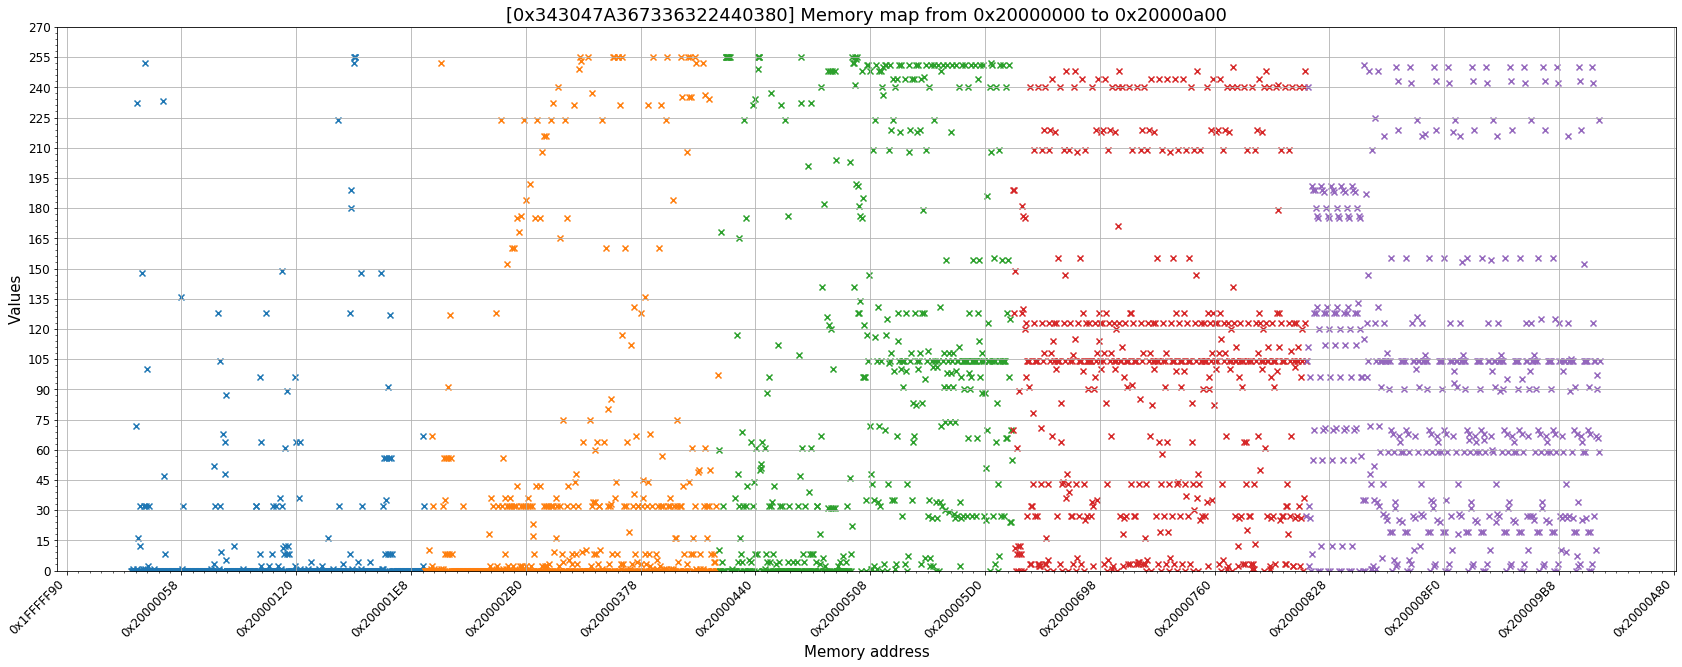

In [248]:
plot_memory_regions(boards_ids[0], 0, 5, show_every=False)

In [250]:
import pandas as pd
from itertools import combinations


def calculate_diff(sample1, sample2):
    '''
    Given two dumps of data, calculate the difference between their data.
    '''
    diff = 0
    for i in range(sample1['length']):
        if sample1['data'][i] != sample2['data'][i]:
            diff = diff + 1

    diff = diff / int(sample1['length'])
    return (diff * 100)


def compare_dumps(board_id, board_dumps):
    '''
    Given a pair of dumps, calculate the difference in % between them.
    Outputs the board_id, the memory position and the difference in the data.
    '''
    column_names = ["Board", "Region", "Sample_1", "Sample_2", "Diff"]
    df = pd.DataFrame(columns=column_names)

    # Every possible starting memory address
    memory_regions = list(set([mem_pos['mem_pos'] for mem_pos in board_dumps]))

    # There are 32 groups, one per region of memory
    for region in memory_regions:

        region_samples = list(db_dumps.find({"mem_pos": region, "board_id": board_id}))
        region_samples = list(combinations(region_samples, 2))

        # Cycle through all of the samples of that memory region
        for i, (sample1, sample2) in enumerate(region_samples):
            diff = calculate_diff(sample1, sample2)

            data = {'Board': board_id,
                    'Region': region,
                    'Sample_1': str(sample1['_id']),
                    'Sample_2': str(sample2['_id']),
                    'Diff': diff}
            df = df.append(data, ignore_index=True)

    return df


def filter_results(data_frame, lower_thresh, upper_thresh, column='Diff'):
    '''
    Filter the results of a data frame.
    The new data frame has values between the given thresholds.
    '''
    is_valid = data_frame[column] > lower_thresh
    data_frame = data_frame[is_valid]

    is_valid = data_frame[column] < upper_thresh
    data_frame = data_frame[is_valid]

    return data_frame


In [251]:
board_ut = boards_ids[10]

board_dumps = list(db_dumps.find({"board_id": board_ut}))

data = compare_dumps(board_ut, board_dumps)
data_valid = filter_results(data, 9.0, 20.0)

pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199

data_valid.sort_values(['Diff'], ascending=[True], inplace=True)
data_valid

,Board,Region,Sample_1,Sample_2,Diff


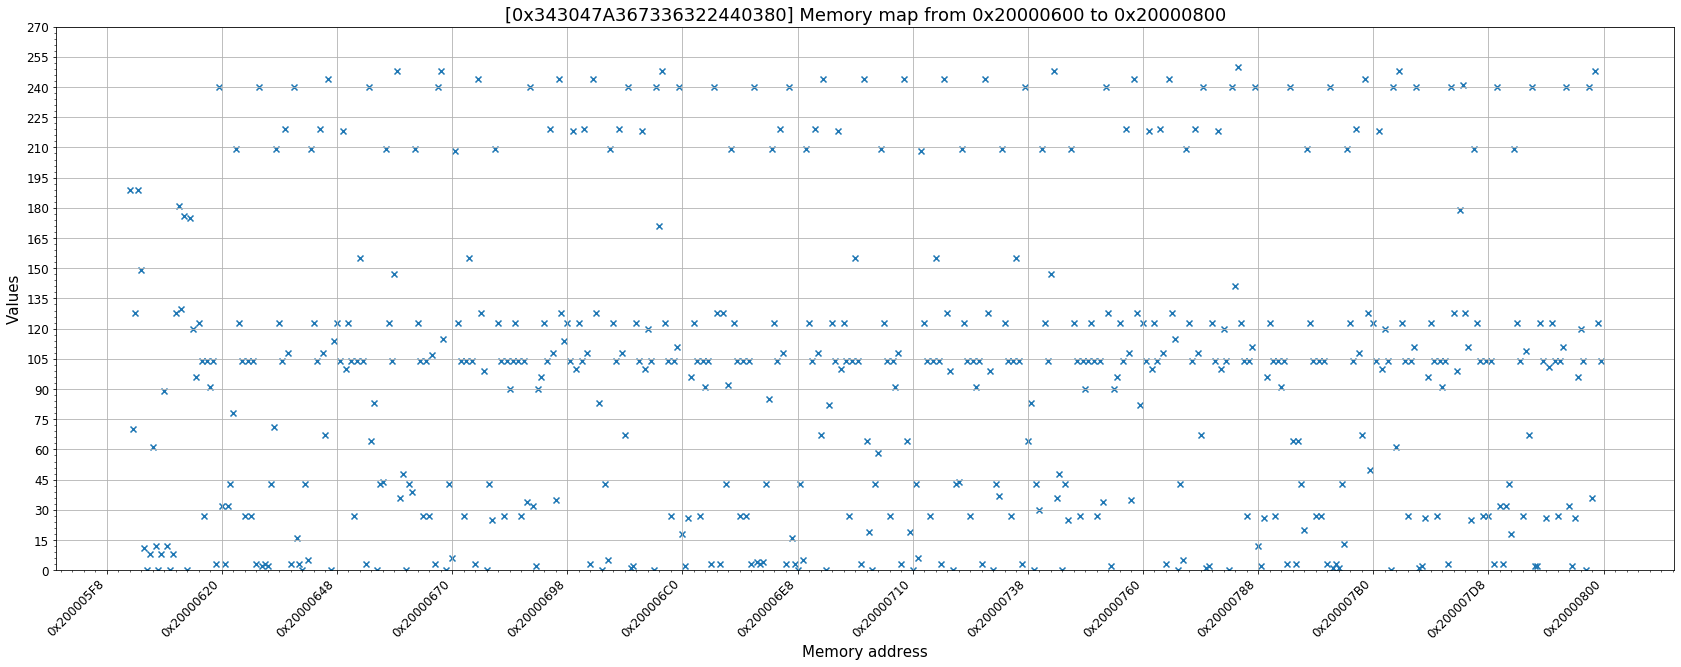

In [252]:
plot_memory_regions(boards_ids[0], 3, 4, show_every=False)

In [254]:
board_dumps = list(db_dumps.find({"board_id": boards_ids[30]}))

data = compare_dumps(boards_ids[1], board_dumps)
data_valid = filter_results(data, 8.0, 18.0)

data_valid.sort_values(['Diff'], ascending=[True], inplace=True)
data_valid

,Board,Region,Sample_1,Sample_2,Diff


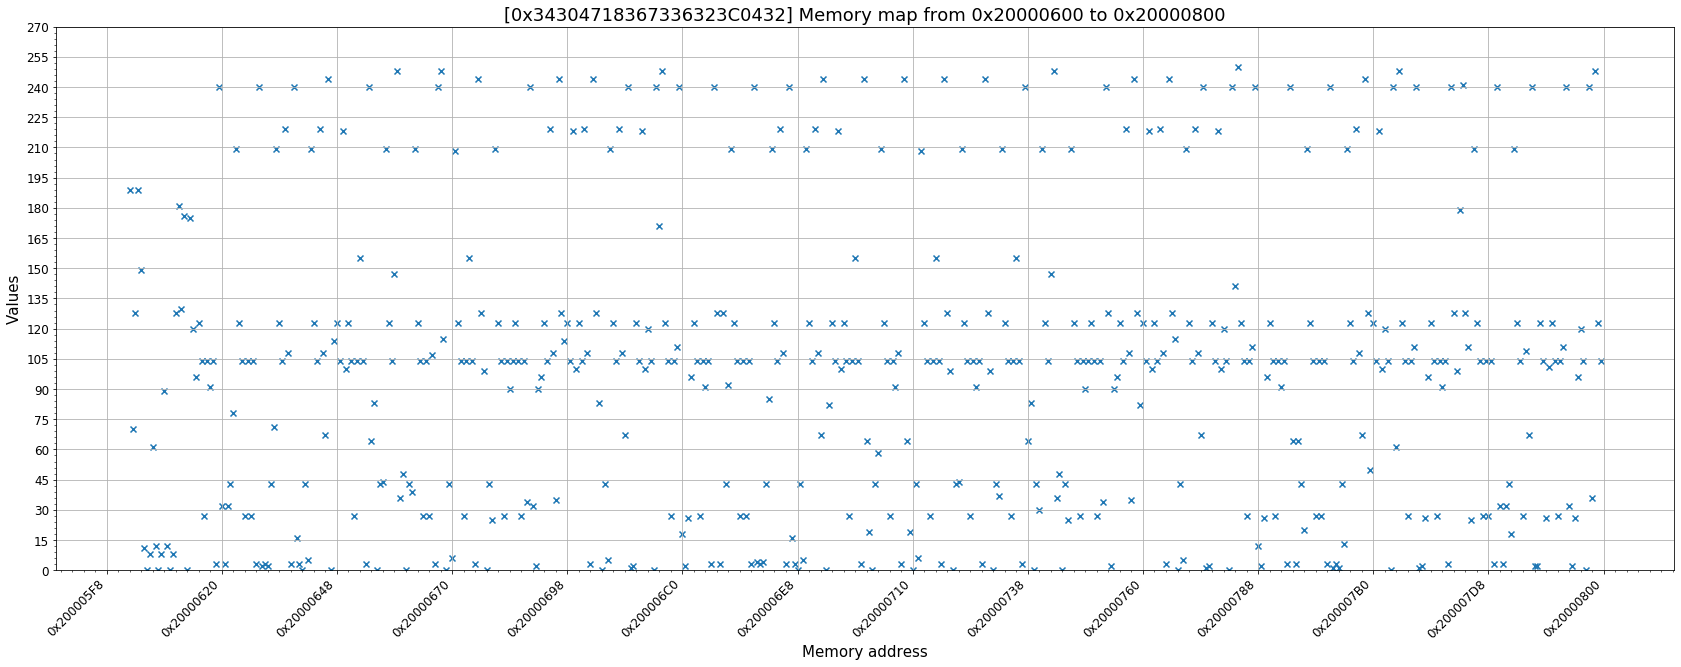

In [255]:
plot_memory_regions(boards_ids[1], 3, 4, show_every=False)

In [258]:
# Compare the same memory region in different boards
memory_regions_ut = list(set([mem_pos['mem_pos'] for mem_pos in board_dumps]))
final_column_names = ["Board_1", "Board_2", "Region", "Sample_Board_1", "Sample_Board_2", "Diff"]

fdata_df = pd.DataFrame(columns=final_column_names)
    
# Loop over all the memory regions
for region_ut in memory_regions_ut:
    # Dumps from the two boards at that memory region
    dumps_board_0 = list(db_dumps.find({'mem_pos': region_ut, 'board_id': boards_ids[30]}))
    dumps_board_1 = list(db_dumps.find({'mem_pos': region_ut, 'board_id': boards_ids[60]}))

    num_samples = min(len(dumps_board_0), len(dumps_board_1))

    # Loop over all of the samples for the memory region under testing
    for sample in range(num_samples):
        diff = calculate_diff(dumps_board_0[sample], dumps_board_1[sample])
    
        data = {'Board_1': dumps_board_0[sample]['board_id'],
                'Board_2': dumps_board_1[sample]['board_id'],
                'Region': region_ut,
                'Sample_Board_1': str(dumps_board_0[sample]['_id']),
                'Sample_Board_2': str(dumps_board_1[sample]['_id']),
                'Diff': diff}
    
        fdata_df = fdata_df.append(data, ignore_index=True)

# Filter the results
final_is_valid = fdata_df['Diff'] < 70
fdata_df = fdata_df[final_is_valid]

fdata_df.sort_values(['Diff'], ascending=[True], inplace=True)
fdata_df

,Board_1,Board_2,Region,Sample_Board_1,Sample_Board_2,Diff
0,0x3430479367336322A20200,0x343047A367336321C0312,0x20002000,5dbb0aaf4fdf3e26d823c048,5dbafc00a710478051e8171c,0.000000
58,0x3430479367336322A20200,0x343047A367336321C0312,0x20001a00,5dbb0aae4fdf3e26d823c045,5dbafbffa710478051e81719,0.000000
56,0x3430479367336322A20200,0x343047A367336321C0312,0x20000e00,5dbb0aad4fdf3e26d823c03f,5dbafbfea710478051e81713,0.000000
54,0x3430479367336322A20200,0x343047A367336321C0312,0x20000c00,5dbb0aad4fdf3e26d823c03e,5dbafbfea710478051e81712,0.000000
52,0x3430479367336322A20200,0x343047A367336321C0312,0x20003200,5dbb0ab04fdf3e26d823c051,5dbafc01a710478051e81725,0.000000
50,0x3430479367336322A20200,0x343047A367336321C0312,0x20002400,5dbb0aaf4fdf3e26d823c04a,5dbafc00a710478051e8171e,0.000000
48,0x3430479367336322A20200,0x343047A367336321C0312,0x20001e00,5dbb0aaf4fdf3e26d823c047,5dbafc00a710478051e8171b,0.000000
46,0x3430479367336322A20200,0x343047A367336321C0312,0x20003400,5dbb0ab04fdf3e26d823c052,5dbafc01a710478051e81726,0.000000
42,0x3430479367336322A20200,0x343047A367336321C0312,0x20003a00,5dbb0ab14fdf3e26d823c055,5dbafc02a710478051e81729,0.000000
40,0x3430479367336322A20200,0x343047A367336321C0312,0x20001600,5dbb0aae4fdf3e26d823c043,5dbafbffa710478051e81717,0.000000


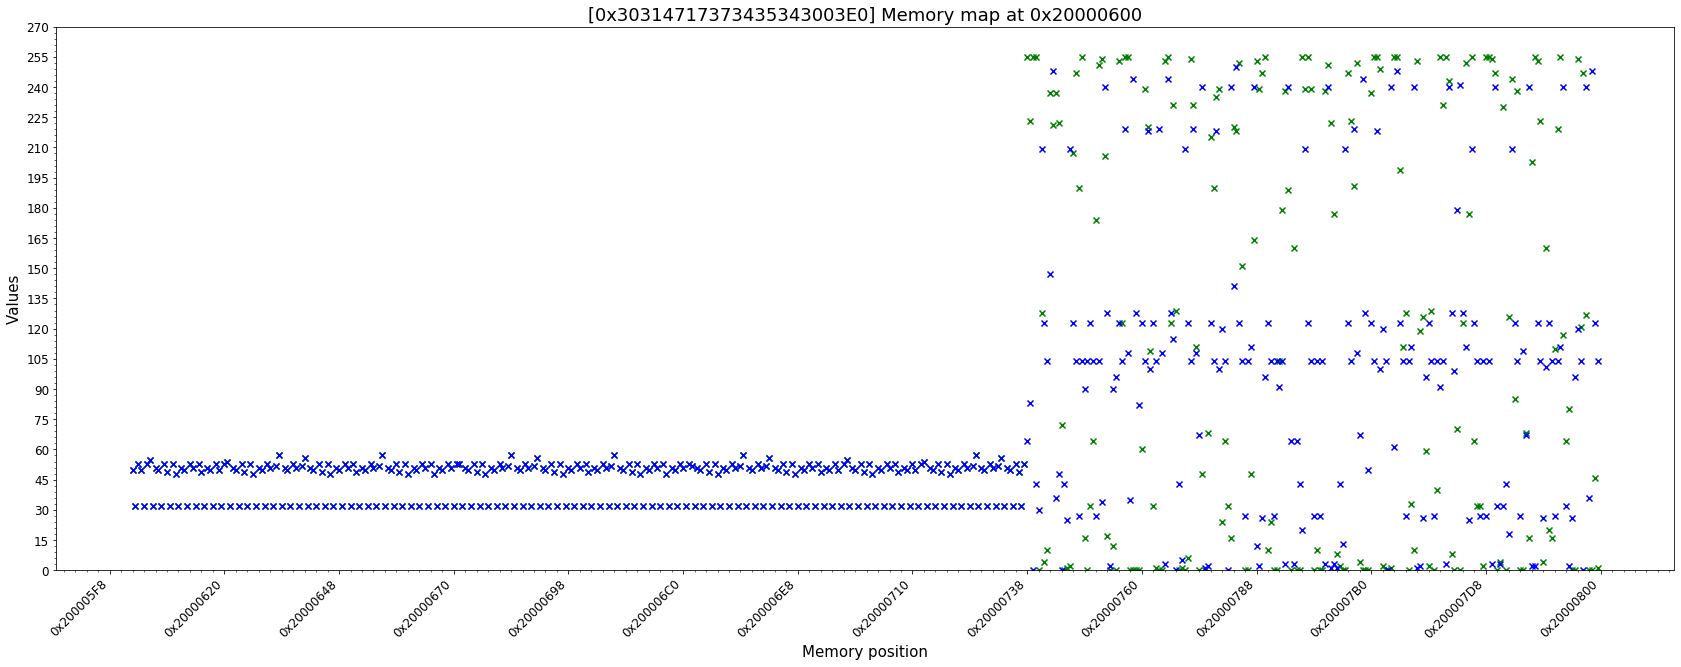

In [139]:
for board in boards_ids:
    plot_memory_regions(board, 3, 4, show_every=False)

In [ ]:
# TODO: Calculate mean and variance of the full memory of a board